In [1]:
# 시계열 데이터 다루기 - 시퀀스 예측 머신러닝 모델

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# 윈도우 데이터 셋
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [12]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:] ) )
for x,y in dataset:
  print(x.numpy(), y.numpy())
  

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [13]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:] ) )
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print(f"x = {x.numpy()}")
  print(f"y = {y.numpy()}")

x = [[5 6 7 8]
 [2 3 4 5]]
y = [[9]
 [6]]
x = [[3 4 5 6]
 [1 2 3 4]]
y = [[7]
 [5]]
x = [[0 1 2 3]
 [4 5 6 7]]
y = [[4]
 [8]]


In [16]:
# 윈도우 개념을 이용한 시계열 데이터셋
def trend(time,slope = 0):
  return time * slope
def seassional_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))  
def seasonality(time, peroid, amplitude = 1, phase=0):
  seassion_time = ((time*phase)%peroid) / peroid
  return  amplitude*seassional_pattern(seassion_time)
def nosie(time, noise_level=1,seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level


In [22]:
time = np.arange(4*365+1, dtype='float32')
series = trend(time,0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time,slope)
series += seasonality(time,peroid=365, amplitude=amplitude)
series += nosie(time, noise_level, seed = 42)

In [24]:
series.shape

(1461,)

In [25]:
def windowed_dataset(series, window_size, batch_size,shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1,shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))  
  
  dataset = dataset.map(lambda window: (window[:-1], window[-1:] ) )
  dataset = dataset.shuffle(shuffle_buffer)  
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [27]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)


In [30]:
dataset = windowed_dataset(series,window_size,1,shuffle_buffer_size)
for feature, label in  dataset.take(1):
  print(feature)
  print(label)

tf.Tensor(
[[113.085754 113.32692  120.057274 111.78352  113.74512  115.479485
  113.46305  110.38783  113.68046  118.16816  107.75743  113.64485
  109.5694   119.13524  105.63406  110.545395 115.31606  121.347626
  113.28125  110.924   ]], shape=(1, 20), dtype=float32)
tf.Tensor([[123.195786]], shape=(1, 1), dtype=float32)


In [55]:
# DNN 모델을 만들고 시퀀스 데이터로 훈련

dataset = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,activation = 'relu', input_shape = [window_size]),
    tf.keras.layers.Dense(10,activation = 'relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss = tf.keras.losses.mse, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4) )

In [56]:
model.fit(dataset,epochs = 100, verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 6107.3154
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 5662.5542
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 5285.1899
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 4976.8521
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 4834.6694
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 4738.5400
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 4637.0347
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 4528.7573
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 4412.6318
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 4290.9761
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 4161.1304
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 3999.1799
E

In [57]:
# DNN 결과 평가
series[1000:1020], series[1020]

(array([126.99678 , 124.71317 , 120.47815 , 117.035324, 123.85112 ,
        122.417435, 125.01597 , 123.80586 , 125.967766, 118.13383 ,
        127.48697 , 121.978004, 131.4563  , 117.72407 , 129.93982 ,
        122.33956 , 118.182915, 119.11058 , 120.018265, 123.83083 ],
       dtype=float32), 124.41418)

In [58]:
model.predict(series[1000:1020][np.newaxis])

1/1 [==============================] - 0s 37ms/step


array([[125.52945]], dtype=float32)

In [59]:
series[1000:1020].shape, series[1000:1020][np.newaxis].shape

((20,), (1, 20))

In [ ]:
forecast = []
for time in range(len(series) - window_size  ):
  forecast.append(
      model.predict(series[time:time+ window_size][np.newaxis])
  )

In [61]:
forecast2 = forecast[split_time - window_size:]
results = np.array(forecast2)[:,0,0]

In [65]:
def plotSeries(time, series, label,format = '-',start=0,end=None):
  plt.plot(time[start:end], series[start:end], format,label=label)
  plt.xlabel('time')
  plt.xlabel('value')
  plt.grid(True)

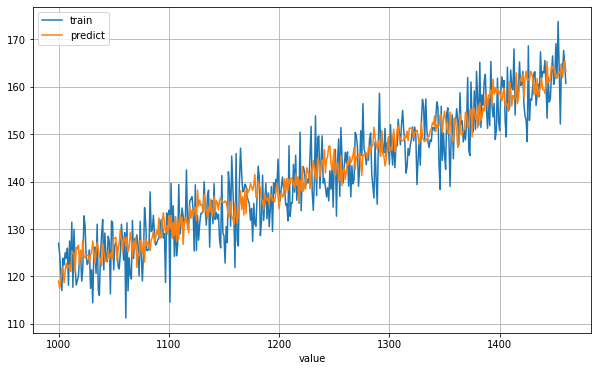

In [67]:
plt.figure(figsize = (10,6))
plotSeries(time_valid, x_valid,'train')
plotSeries(time_valid, results,'predict')
plt.legend()

In [ ]:
!pip install keras-tuner

In [69]:
from keras_tuner.tuners import RandomSearch

In [70]:
def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(
    units=hp.Int('units', min_value=10, max_value=30, step=2),
    activation='relu', input_shape=[window_size]))
  model.add(tf.keras.layers.Dense(10,activation='relu'))
  model.add(tf.keras.layers.Dense(1))
  sgd = tf.keras.optimizers.SGD(
      learning_rate = 1e-4, momentum = hp.Choice('momentum', values = [.9,.7,.5,.3])
  )
  model.compile(loss='mse', optimizer= sgd)
  return model

In [71]:
tuner = RandomSearch(build_model, objective='loss', max_trials=150,executions_per_trial=3
             , directory = 'my_dir', project_name='hello', overwrite = True)

In [ ]:
tuner.search(dataset, epochs=100, verbose=0)

In [ ]:
tuner.results_summary()

In [ ]:
best_models =  tuner.get_best_models()